In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import rel_entr
import seaborn as sns

In [2]:
plt.style.use('matplot.mplstyle')

# Is information from the forget set still present in the unlearned model?

### SOTA Membership Inference on unlearned model
The code below conducts the SOTA membership inference (LiRA, Carlini et al (2021)) attack on the unlearned models. As a baseline we will use the LiRA attack on train versus test points. Further, we will probe both unlearning algorithms by: 
- changing the learning rate for GA; and changing the context length for ICUL 
- changing the underlying model's size from Bloom560m to Bloom1b1
- changing the scrubbing context on the yelp_polarity dataset (from 'vary' to one of {'ablation-rep', 'ablation-correct'})

In [3]:
''' this loads the data from the csv files'''
def get_data(model_name, nctxt, lr, mode, n, ubs, regime, context_style, dataset_name, indices):
    dfa_list = []
    for i in indices:
        if mode == 'icl':
            dfa = pd.read_csv(f'nctxt{nctxt}/results_{dataset_name}_{model_name}_model{i}_{mode}_n{n}_mepochs1_uepochs1_bs{ubs}_{context_style}_nctxt{nctxt}_{regime}.csv', index_col=False)
        else:
            dfa = pd.read_csv(f'bs{ubs}/results_{dataset_name}_{model_name}_model{i}_{mode}_n{n}_mepochs1_uepochs1_bs{ubs}_lr{lr}.csv', index_col=False)
        dfa_list.append(dfa)
    ind_mask_all = pd.read_csv(f"nctxt{nctxt}/{dataset_name}_mask_epochs1_unlearnbs{ubs}.csv", index_col=False).to_numpy()
    # ind_mask_all_extended = pd.read_csv(f"nctxt{nctxt}/{dataset_name}_extendedmask_epochs1_unlearnbs{ubs}.csv", index_col=False).to_numpy()
    return dfa_list, ind_mask_all

In [4]:
def get_losses(losses_ordered_forget, 
               losses_ordered_test, 
               ind_mask_all, 
               model_k, 
               bs):
        
    ph = []
    counter_forget = 0
    counter_test = 0
    for i in range(ind_mask_all.shape[0]):
        if ind_mask_all[i, model_k]:
            for j in range(bs):
                ph.append(losses_ordered_forget[counter_forget])
                counter_forget += 1
        else:
            for j in range(bs):
                ph.append(losses_ordered_test[counter_test])
                counter_test += 1
    return np.array(ph)

In [5]:
def get_scores(df_list_, ind_mask, indices, forget: str, test: str):
    M = len(df_list_)
    scores = np.zeros((df_list_[0].shape[0]*2, M))
    for iter_j, m_idx in enumerate(indices):
        s = get_losses(losses_ordered_forget=df_list_[iter_j][forget], 
                       losses_ordered_test=df_list_[iter_j][test],
                       ind_mask_all=ind_mask, 
                       model_k=m_idx, 
                       bs=1)
        scores[:,iter_j] = s
    return scores

In [6]:
def split_scores(scores, ind_mask_all, min_keep=3, lrt=False, idx_t0=0):
    n_keep = min_keep - 1
    if lrt:
        # overwrite this as we have one less model available
        n_keep = n_keep - 1
        M = scores.shape[1]
        # t0 data with arbitrary idx (i.e., model idx to be attacked)
        mask_t0 =  ind_mask_all[:, idx_t0]
        t0 = scores[:, idx_t0]
        # remaining data
        other_inds = np.delete(range(M), idx_t0).tolist()
        ind_mask_all = ind_mask_all[:,other_inds]
        scores = scores[:, other_inds]
        # compute ins and outs
        maskin = ind_mask_all * 1
        maskout = (~ind_mask_all) * 1
        scores_in = scores * maskin
        scores_out = scores * maskout
        # make sure to have at least min_keep
        nzi = np.zeros(scores_in.shape[0], dtype=bool)
        non_zeros_in = np.where(np.sum(maskin, axis=1) > n_keep)[0]
        nzi[non_zeros_in] = True
        nzo = np.zeros(scores_out.shape[0], dtype=bool)
        non_zeros_out = np.where(np.sum(maskout, axis=1) > n_keep)[0]
        nzo[non_zeros_out] = True
        ind_keep = np.where(((nzi*1)*(nzo*1))!=0)[0]
        # update everything
        scores_in = scores_in[ind_keep]   # update scores in
        scores_out = scores_out[ind_keep] # update scores out
        t0 = t0[ind_keep]                 # update t0
        mask_t0 = mask_t0[ind_keep]       # update mask
        # compute averages
        normalizer_in = np.count_nonzero(scores_in, axis=1)
        normalizer_out = np.count_nonzero(scores_out, axis=1)
        m_scores_unlearned = np.sum(scores_in, axis=1)/normalizer_in
        m_scores_retained = np.sum(scores_out, axis=1)/normalizer_out
        return m_scores_unlearned, m_scores_retained, t0, mask_t0
    else:
        maskin = ind_mask_all * 1
        maskout = (~ind_mask_all) * 1
        scores_in = scores * maskin
        scores_out = scores * maskout
        # make sure to have at least min_keep
        nzi = np.zeros(scores_in.shape[0], dtype=bool)
        non_zeros_in = np.where(np.sum(maskin, axis=1)>n_keep)[0]
        nzi[non_zeros_in] = True
        nzo = np.zeros(scores_out.shape[0], dtype=bool)
        non_zeros_out = np.where(np.sum(maskout, axis=1)>n_keep)[0]
        nzo[non_zeros_out] = True
        ind_keep = np.where(((nzi*1)*(nzo*1))!=0)[0]
        scores_in = scores_in[ind_keep]
        scores_out = scores_out[ind_keep]
        # averages over in/out models
        normalizer_in = np.count_nonzero(scores_in, axis=1)
        normalizer_out = np.count_nonzero(scores_out, axis=1)
        m_scores_unlearned = np.sum(scores_in, axis=1)/normalizer_in
        m_scores_retained = np.sum(scores_out, axis=1)/normalizer_out
        return m_scores_unlearned, m_scores_retained

In [7]:
def get_lrt_scores(t0, mask_t0, m_scores_unlearn_lrt, m_scores_holdout_lrt, global_var):
    # this compute lrt scores for the LiRA attack
    mean_scores_unlearn_lrt = np.mean(m_scores_unlearn_lrt)
    mean_scores_holdout_lrt = np.mean(m_scores_holdout_lrt)
    std_unlearn = np.std(m_scores_unlearn_lrt)
    std_holdout = np.std(m_scores_holdout_lrt)
    if global_var:
        overall_std_lrt = np.std(np.array([m_scores_unlearn_lrt, m_scores_holdout_lrt]))
        std_unlearn = overall_std_lrt
        std_holdout = overall_std_lrt
    pr_in_lrt = - norm.logpdf(t0, m_scores_unlearn_lrt, std_unlearn+1e-15)
    pr_out_lrt = - norm.logpdf(t0, m_scores_holdout_lrt, std_holdout+1e-15)
    scores_lrt = pr_in_lrt - pr_out_lrt 
    m_scores_unlearn_lrt = scores_lrt[mask_t0]
    m_scores_holdout_lrt = scores_lrt[~mask_t0]
    return m_scores_unlearn_lrt, m_scores_holdout_lrt

In [8]:
from sklearn import metrics
def compute_curve(train_scores: np.array, test_scores: np.array, pos_label=1):
    y = np.r_[np.ones(np.shape(train_scores)[0]), np.zeros(np.shape(test_scores)[0])]
    fs, ts, thresholds = metrics.roc_curve(y, np.r_[train_scores, test_scores], pos_label=pos_label)
    return ts, fs

In [9]:
# setup
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n = 12500
ubs = 1
mode = 'icl'
model_name = 'bloom-1b1'
iters = len(indices)
global_var = False
GA_flag = True
# '1e-05' # most competetive learning rate
lr = '1e-05'
lrs = ['1e-05', '3e-05', '5e-05']
mean_fpr = np.linspace(0, 1, 10000)
# dataset options: {'imdb', 'yelp_polarity', 'sst2', 'amazon_polarity'}
ubs = 1
datasets = ['amazon_polarity', 'yelp_polarity', 'sst2']  
regime = 'lfmfirst-k'
mode = 'icl'
context_style = 'vary'

In [10]:
''' This is to plot confidence intervals for the ROC curves '''
overall_results = {}
# start loop [only loop over 2 & 5 as 3 and 4 give similar results. That way loop goes faster.]
for dataset_name in datasets:
    print(f'dataset: {dataset_name}')
    if dataset_name == 'yelp_polarity':
        ctxt_lengths = [2, 4, 6]
    else:
        ctxt_lengths = [2, 4, 6, 8]
    min_keep_results = {}
    for min_keep in [2, 5]:
        '''Here we loop over different min_keep scores which control how average results; 
           i.e., we average when we have at least >2-1<, >3-1<, >4-1<, or >5-1< observations 
           to average over)'''
        print(f'min keep: {min_keep}')
        results = {'metric_icl': {'2': {'tprs': [], 'aucs': []},
                                  '4': {'tprs': [], 'aucs': []},
                                  '6': {'tprs': [], 'aucs': []},
                                  '8': {'tprs': [], 'aucs': []}},
                    'metric_ga':  {'1e-05': {'tprs': [], 'aucs': []},
                                   '3e-05': {'tprs': [], 'aucs': []},
                                   '5e-05': {'tprs': [], 'aucs': []}},
                    'metric_base1': {'tprs': [], 'aucs': []},
                    'metric_base2': {'tprs': [], 'aucs': []}
                    }
        ''' Here we loop over different models t_0 to make sure we obtain confidence intervals. 
           Since we have trained N=10 model, we can compute the stand. dev. over these 10 models. '''
        for idx_t0 in range(iters):
            print(f'iteration: {idx_t0}')
            for i, nctxt in enumerate(ctxt_lengths):
                print('Context length:', nctxt)
                dflist, ind_mask_all = get_data(model_name=model_name,
                                                nctxt=nctxt, lr=lr, mode=mode, n=n, ubs=ubs, 
                                                context_style=context_style, regime=regime,
                                                dataset_name=dataset_name, indices=indices)    

                # forget vs holdout
                scores_0 = get_scores(dflist, ind_mask_all, indices, forget='losses_icl_forget_0', test='losses_icl_test_0')
                m_scores_unlearned_lrt, m_scores_retained_lrt0, t00, mask_t00 = split_scores(scores_0, ind_mask_all, min_keep=min_keep, lrt=True, idx_t0=idx_t0)
                m_scores_unlearned_lrt, m_scores_retained_lrt0 = get_lrt_scores(t00, mask_t00, m_scores_unlearned_lrt, m_scores_retained_lrt0, global_var)

                # start collecting the meat
                ts_icl, fs_icl = compute_curve(m_scores_unlearned_lrt, m_scores_retained_lrt0, pos_label=0)
                auc_icl = np.round(metrics.auc(fs_icl, ts_icl), 2)
                interp_tpr_icl = np.interp(mean_fpr, fs_icl, ts_icl)
                interp_tpr_icl[0] = 0.0
                results['metric_icl'][str(nctxt)]['tprs'].append(interp_tpr_icl)
                results['metric_icl'][str(nctxt)]['aucs'].append(auc_icl)
            
                # GA: forget vs holdout
                if GA_flag:
                    if i <= len(lrs)-1:
                        lr = lrs[i]
                        if not (dataset_name == 'amazon_polarity' and (lr == '3e-05' or lr == '5e-05')):
                            dflist_ga, ind_mask_all_ga = get_data(model_name=model_name,
                                                                  nctxt=nctxt, lr=lr, mode='GA', n=n, ubs=ubs, 
                                                                  context_style=context_style, regime=regime,
                                                                  dataset_name=dataset_name, indices=indices)
                            scores_ga = get_scores(dflist_ga, ind_mask_all_ga, indices, forget='losses_ga_forget_0', test='losses_ga_test_0')
                            m_scores_unlearned_lrt_ga, m_scores_retained_lrt_ga, t_ga, mask_t_ga = split_scores(scores_ga, ind_mask_all, min_keep=min_keep, lrt=True, idx_t0=idx_t0)
                            m_scores_unlearned_lrt_ga, m_scores_retained_lrt_ga = get_lrt_scores(t_ga, mask_t_ga, m_scores_unlearned_lrt_ga, m_scores_retained_lrt_ga, global_var)

                            ''' GA '''
                            ts_base_ga, fs_base_ga = compute_curve(m_scores_unlearned_lrt_ga, m_scores_retained_lrt_ga, pos_label=0)
                            auc_base_ga = np.round(metrics.auc(fs_base_ga, ts_base_ga), 2)
                            interp_tpr_ga = np.interp(mean_fpr, fs_base_ga, ts_base_ga)
                            interp_tpr_ga[0] = 0.0
                            results['metric_ga'][lr]['tprs'].append(interp_tpr_ga)
                            results['metric_ga'][lr]['aucs'].append(auc_base_ga)

                if i == 0:
                    # train vs holdout
                    scores_1 = get_scores(dflist, ind_mask_all, indices, forget='losses_base_forget_0', test='losses_base_test_0')
                    m_scores_forget_lrt, m_scores_retained_lrt1, t01, mask_t01 = split_scores(scores_1, ind_mask_all, min_keep=min_keep, lrt=True, idx_t0=idx_t0)
                    m_scores_forget_lrt, m_scores_retained_lrt1 = get_lrt_scores(t01, mask_t01, m_scores_forget_lrt, m_scores_retained_lrt1, global_var)

                    ''' BASELINE '''
                    ts_base1, fs_base1 = compute_curve(m_scores_forget_lrt, m_scores_retained_lrt1, pos_label=0)
                    auc_base1 = np.round(metrics.auc(fs_base1, ts_base1), 2)
                    interp_tpr_base1 = np.interp(mean_fpr, fs_base1, ts_base1)
                    interp_tpr_base1[0] = 0.0
                    results['metric_base1']['tprs'].append(interp_tpr_base1)
                    results['metric_base1']['aucs'].append(auc_base1)

        min_keep_results[f'min_keep{min_keep}'] = results
    overall_results[dataset_name] = min_keep_results

dataset: amazon_polarity
min keep: 2
iteration: 0
Context length: 2
Context length: 4
Context length: 6
Context length: 8
iteration: 1
Context length: 2
Context length: 4
Context length: 6
Context length: 8
iteration: 2
Context length: 2
Context length: 4
Context length: 6
Context length: 8
iteration: 3
Context length: 2
Context length: 4
Context length: 6
Context length: 8
iteration: 4
Context length: 2
Context length: 4
Context length: 6
Context length: 8
iteration: 5
Context length: 2
Context length: 4
Context length: 6
Context length: 8
iteration: 6
Context length: 2
Context length: 4
Context length: 6
Context length: 8
iteration: 7
Context length: 2
Context length: 4
Context length: 6
Context length: 8
iteration: 8
Context length: 2
Context length: 4
Context length: 6
Context length: 8
iteration: 9
Context length: 2
Context length: 4
Context length: 6
Context length: 8
min keep: 5
iteration: 0
Context length: 2
Context length: 4
Context length: 6
Context length: 8
iteration: 1
Con

## Main paper - Compare: Baseline vs GA vs ICUL

### Collect results for table

In [135]:
''' This is to plot confidence intervals for the ROC curves '''
ctxt_lengths = [2, 4, 6]
m_keeps = [2]
mean_fpr = [0.001, 0.01, 0.1]
# start loop [only loop over 2 & 5 as 3 and 4 give similar results. That way loop goes faster.]
overkill_results = {}
for model_name in ['bloom-560m', 'bloom-1b1']:
    print(model_name)
    overall_results = {}
    for dataset_name in datasets:
        print(f'dataset: {dataset_name}')
        min_keep_results = {}
        for min_keep in m_keeps:
            '''Here we loop over different min_keep scores which control how average results; 
               i.e., we average when we have at least >2-1<, >3-1<, >4-1<, or >5-1< observations 
               to average over)'''
            print(f'min keep: {min_keep}')
            results = {'metric_icl': {'2': {'tprs': [], 'aucs': []},
                                      '4': {'tprs': [], 'aucs': []},
                                      '6': {'tprs': [], 'aucs': []},
                                      '8': {'tprs': [], 'aucs': []}},
                        'metric_ga':  {'1e-05': {'tprs': [], 'aucs': []},
                                       '3e-05': {'tprs': [], 'aucs': []},
                                       '5e-05': {'tprs': [], 'aucs': []}},
                        'metric_base1': {'tprs': [], 'aucs': []},
                        'metric_base2': {'tprs': [], 'aucs': []}
                        }
            ''' Here we loop over different models t_0 to make sure we obtain confidence intervals. 
               Since we have trained N=10 model, we can compute the stand. dev. over these 10 models. '''
            for idx_t0 in range(iters):
                print(f'iteration: {idx_t0}')
                for i, nctxt in enumerate(ctxt_lengths):
                    print('Context length:', nctxt)
                    dflist, ind_mask_all = get_data(model_name=model_name,
                                                    nctxt=nctxt, lr=lr, mode=mode, n=n, ubs=ubs, 
                                                    context_style=context_style, regime=regime,
                                                    dataset_name=dataset_name, indices=indices)    

                    # forget vs holdout
                    scores_0 = get_scores(dflist, ind_mask_all, indices, forget='losses_icl_forget_0', test='losses_icl_test_0')
                    m_scores_unlearned_lrt, m_scores_retained_lrt0, t00, mask_t00 = split_scores(scores_0, ind_mask_all, min_keep=min_keep, lrt=True, idx_t0=idx_t0)
                    m_scores_unlearned_lrt, m_scores_retained_lrt0 = get_lrt_scores(t00, mask_t00, m_scores_unlearned_lrt, m_scores_retained_lrt0, global_var)

                    # start collecting the meat
                    ts_icl, fs_icl = compute_curve(m_scores_unlearned_lrt, m_scores_retained_lrt0, pos_label=0)
                    auc_icl = np.round(metrics.auc(fs_icl, ts_icl), 2)
                    interp_tpr_icl = np.interp(mean_fpr, fs_icl, ts_icl)
                    # interp_tpr_icl[0] = 0.0
                    results['metric_icl'][str(nctxt)]['tprs'].append(interp_tpr_icl)
                    results['metric_icl'][str(nctxt)]['aucs'].append(auc_icl)

                    # GA: forget vs holdout
                    if GA_flag:
                        if i <= len(lrs)-1:
                            lr = lrs[i]
                            if not (dataset_name == 'amazon_polarity' and (lr == '3e-05' or lr == '5e-05')):
                                dflist_ga, ind_mask_all_ga = get_data(model_name=model_name,
                                                                      nctxt=nctxt, lr=lr, mode='GA', n=n, ubs=ubs, 
                                                                      context_style=context_style, regime=regime,
                                                                      dataset_name=dataset_name, indices=indices)
                                scores_ga = get_scores(dflist_ga, ind_mask_all_ga, indices, forget='losses_ga_forget_0', test='losses_ga_test_0')
                                m_scores_unlearned_lrt_ga, m_scores_retained_lrt_ga, t_ga, mask_t_ga = split_scores(scores_ga, ind_mask_all, min_keep=min_keep, lrt=True, idx_t0=idx_t0)
                                m_scores_unlearned_lrt_ga, m_scores_retained_lrt_ga = get_lrt_scores(t_ga, mask_t_ga, m_scores_unlearned_lrt_ga, m_scores_retained_lrt_ga, global_var)

                                ''' GA '''
                                ts_base_ga, fs_base_ga = compute_curve(m_scores_unlearned_lrt_ga, m_scores_retained_lrt_ga, pos_label=0)
                                auc_base_ga = np.round(metrics.auc(fs_base_ga, ts_base_ga), 2)
                                interp_tpr_ga = np.interp(mean_fpr, fs_base_ga, ts_base_ga)
                                # interp_tpr_ga[0] = 0.0
                                results['metric_ga'][lr]['tprs'].append(interp_tpr_ga)
                                results['metric_ga'][lr]['aucs'].append(auc_base_ga)

                    if i == 0:
                        # train vs holdout
                        scores_1 = get_scores(dflist, ind_mask_all, indices, forget='losses_base_forget_0', test='losses_base_test_0')
                        m_scores_forget_lrt, m_scores_retained_lrt1, t01, mask_t01 = split_scores(scores_1, ind_mask_all, min_keep=min_keep, lrt=True, idx_t0=idx_t0)
                        m_scores_forget_lrt, m_scores_retained_lrt1 = get_lrt_scores(t01, mask_t01, m_scores_forget_lrt, m_scores_retained_lrt1, global_var)

                        ''' BASELINE '''
                        ts_base1, fs_base1 = compute_curve(m_scores_forget_lrt, m_scores_retained_lrt1, pos_label=0)
                        auc_base1 = np.round(metrics.auc(fs_base1, ts_base1), 2)
                        interp_tpr_base1 = np.interp(mean_fpr, fs_base1, ts_base1)
                        # interp_tpr_base1[0] = 0.0
                        results['metric_base1']['tprs'].append(interp_tpr_base1)
                        results['metric_base1']['aucs'].append(auc_base1)

            min_keep_results[f'min_keep{min_keep}'] = results
        overall_results[dataset_name] = min_keep_results
    overkill_results[model_name] = overall_results

bloom-560m
dataset: amazon_polarity
min keep: 2
iteration: 0
Context length: 2
Context length: 4
Context length: 6
iteration: 1
Context length: 2
Context length: 4
Context length: 6
iteration: 2
Context length: 2
Context length: 4
Context length: 6
iteration: 3
Context length: 2
Context length: 4
Context length: 6
iteration: 4
Context length: 2
Context length: 4
Context length: 6
iteration: 5
Context length: 2
Context length: 4
Context length: 6
iteration: 6
Context length: 2
Context length: 4
Context length: 6
iteration: 7
Context length: 2
Context length: 4
Context length: 6
iteration: 8
Context length: 2
Context length: 4
Context length: 6
iteration: 9
Context length: 2
Context length: 4
Context length: 6
dataset: yelp_polarity
min keep: 2
iteration: 0
Context length: 2
Context length: 4
Context length: 6
iteration: 1
Context length: 2
Context length: 4
Context length: 6
iteration: 2
Context length: 2
Context length: 4
Context length: 6
iteration: 3
Context length: 2
Context length:

In [17]:
mean_fpr
#overkill_results

[0.001, 0.01, 0.1]

In [188]:
dataset_tables = []
for dataset in datasets:
    model_tables = []
    for model in ['bloom-560m', 'bloom-1b1']:
        collect_them = []
        for metric in ['metric_base1', 'metric_icl', 'metric_ga']:
            collect_mean = []
            collect_std = []
            for measure in ['aucs', 'tprs']:
                if metric == 'metric_icl':
                    if dataset == 'yelp_polarity' or dataset == 'amazon_polarity':
                        length = '4'
                    else:
                        length = '6'
                    r = overkill_results[model][dataset]['min_keep2'][metric][length][measure]
                elif metric == 'metric_ga':
                    r = overkill_results[model][dataset]['min_keep2'][metric]['1e-05'][measure]
                else:
                    r = overkill_results[model][dataset]['min_keep2'][metric][measure]
                if measure == 'tprs':
                    r_mean = np.array(r).mean(axis=0).round(4)
                    r_std = np.array(r).std(axis=0).round(4)
                else:
                    r_mean = np.array(r).mean().round(4)
                    r_std = np.array(np.array(r)).std().round(4)
                collect_mean.append(r_mean)
                collect_std.append(r_std)
            #print(collect_std)
            c = [f'${collect_mean[0]} \pm {collect_std[0]}$']
            for i in range(3):
                c.append(f'${collect_mean[1][i]} \pm {collect_std[1][i]}$')
            #collect = np.r_[np.array([f'{collect_mean[0]}' + f'{collect_std[0]}', ]), collect[1]].T
            collect_them.append(c)
        model_tables.append(collect_them)
    data_table = np.c_[np.array(model_tables[0]).T, np.array(model_tables[1]).T]
    dataset_tables.append(data_table)
dataset_tables
full_table = np.r_[dataset_tables[0], dataset_tables[1], dataset_tables[2]]
full_table = pd.DataFrame(full_table)
full_table.columns = ['Baseline', 'ICUL', 'GA', 'Baseline', 'ICUL', 'GA']

In [189]:
full_table.style.to_latex()

'\\begin{tabular}{lllllll}\n & Baseline & ICUL & GA & Baseline & ICUL & GA \\\\\n0 & $0.542 \\pm 0.004$ & $0.506 \\pm 0.0049$ & $0.587 \\pm 0.0149$ & $0.557 \\pm 0.009$ & $0.522 \\pm 0.0108$ & $0.674 \\pm 0.041$ \\\\\n1 & $0.0043 \\pm 0.0016$ & $0.0013 \\pm 0.0006$ & $0.0008 \\pm 0.0004$ & $0.0046 \\pm 0.0011$ & $0.0015 \\pm 0.0008$ & $0.0017 \\pm 0.0007$ \\\\\n2 & $0.0251 \\pm 0.0028$ & $0.0114 \\pm 0.003$ & $0.0106 \\pm 0.0017$ & $0.03 \\pm 0.0019$ & $0.0112 \\pm 0.0037$ & $0.0173 \\pm 0.0038$ \\\\\n3 & $0.1403 \\pm 0.0046$ & $0.1028 \\pm 0.0141$ & $0.1491 \\pm 0.0082$ & $0.1536 \\pm 0.0124$ & $0.0986 \\pm 0.0161$ & $0.2164 \\pm 0.0446$ \\\\\n4 & $0.569 \\pm 0.043$ & $0.503 \\pm 0.011$ & $0.659 \\pm 0.0584$ & $0.558 \\pm 0.0183$ & $0.509 \\pm 0.0181$ & $0.679 \\pm 0.0552$ \\\\\n5 & $0.0068 \\pm 0.0037$ & $0.001 \\pm 0.0004$ & $0.0021 \\pm 0.0012$ & $0.0074 \\pm 0.0016$ & $0.0006 \\pm 0.0004$ & $0.0014 \\pm 0.0006$ \\\\\n6 & $0.0323 \\pm 0.0111$ & $0.01 \\pm 0.0037$ & $0.0219 \\pm 0.0

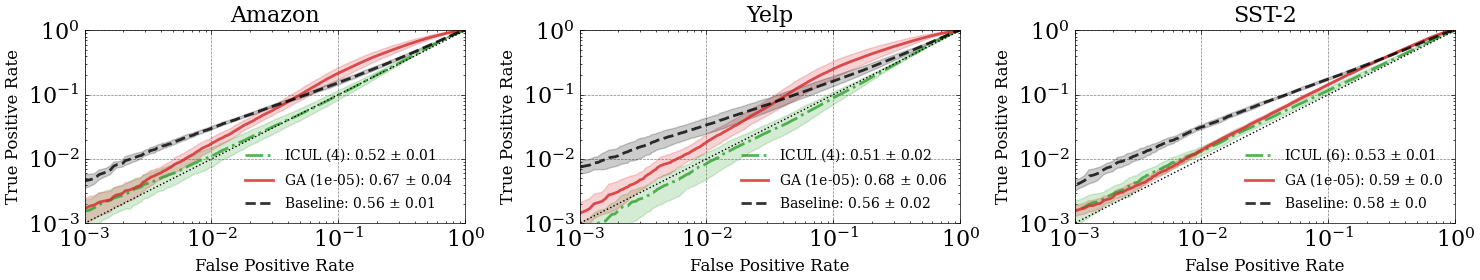

In [11]:
dataset_names = ['Amazon', 'Yelp', 'SST-2'] #['IMDb', 'Amazon', 'Yelp', 'SST-2']
fig, axs = plt.subplots(1, len(datasets), figsize=(len(datasets)*5, 3))
savingtype = 'pdf'
min_keep = '2'
lr = '1e-05'
for id_data, dataset_name in enumerate(datasets):
    if dataset_name == 'yelp_polarity':
        ctxt_lengths = [4]
    elif dataset_name == 'amazon_polarity':
        ctxt_lengths = [4]
    elif dataset_name == 'sst2':
        ctxt_lengths = [6]
    results = overall_results[dataset_name][f'min_keep{min_keep}']
    for i, nctxt in enumerate(ctxt_lengths):
        '''ICUL'''
        tprs_u = np.array(results['metric_icl'][f'{nctxt}']['tprs']).T
        aucs_u = np.array(results['metric_icl'][f'{nctxt}']['aucs']).T
        mean_tpr_u = np.mean(tprs_u, axis=1)
        std_tpr_u = np.std(tprs_u, axis=1)
        mean_tpr_u[-1] = 1.0
        mean_auc_u = np.mean(aucs_u).round(2)
        std_auc_u = np.std(aucs_u).round(2)
        
        # Unlearn vs Holdout
        axs[id_data].loglog(mean_fpr, mean_tpr_u,
                            label=f"ICUL ({nctxt}): %0.2f $\pm$ %0.2f" % (mean_auc_u, std_auc_u), 
                            lw=2, alpha=0.8, linestyle='dashdot', color='tab:green')
        tprs_upper_u = mean_tpr_u + std_tpr_u #np.minimum(mean_tpr_u + std_tpr_u, 1)
        tprs_lower_u = mean_tpr_u - std_tpr_u #np.maximum(mean_tpr_u - std_tpr_u, 0)
        axs[id_data].fill_between(mean_fpr, tprs_lower_u, tprs_upper_u, alpha=0.2, color='tab:green') #label=r"$\pm$ 1 std. dev.")

    '''GA'''
    if GA_flag:
        tprs_ga = np.array(results['metric_ga'][lr]['tprs']).T
        aucs_ga = np.array(results['metric_ga'][lr]['aucs']).T
        mean_tpr_ga = np.mean(tprs_ga, axis=1)
        std_tpr_ga = np.std(tprs_ga, axis=1)
        mean_tpr_ga[-1] = 1.0
        mean_auc_ga = np.mean(aucs_ga).round(2)
        std_auc_ga = np.std(aucs_ga).round(2)
        
        # Unlearn vs Holdout
        axs[id_data].loglog(mean_fpr, mean_tpr_ga, 
                            label=f"GA ({lr}): {mean_auc_ga} $\pm$ {std_auc_ga}", 
                            lw=2, alpha=0.8, linestyle='solid', color='tab:red')
        tprs_upper_ga = mean_tpr_ga + std_tpr_ga # np.minimum(mean_tpr_u + std_tpr_u, 1)
        tprs_lower_ga = mean_tpr_ga - std_tpr_ga # np.maximum(mean_tpr_u - std_tpr_u, 0)
        axs[id_data].fill_between(mean_fpr, tprs_lower_ga, tprs_upper_ga, alpha=0.2, color='tab:red') 

    ''' BASELINES '''
    tprs_b = np.array(results[f'metric_base1']['tprs']).T
    aucs_b = np.array(results[f'metric_base1']['aucs']).T
    mean_tpr_b = np.mean(tprs_b, axis=1)
    std_tpr_b = np.std(tprs_b, axis=1)
    mean_tpr_b[-1] = 1.0
    mean_auc_b = np.mean(aucs_b).round(2)
    std_auc_b = np.std(aucs_b).round(2)
    label = 'Baseline' #'Train v. Holdout'
    axs[id_data].loglog(mean_fpr, mean_tpr_b, 
                        label=f"{label}: {mean_auc_b} $\pm$ {std_auc_b}", 
                        lw=2, alpha=0.8, linestyle='dashed', color='black')
    tprs_upper_b = np.minimum(mean_tpr_b + std_tpr_b, 1)
    tprs_lower_b = np.maximum(mean_tpr_b - std_tpr_b, 0)
    axs[id_data].fill_between(mean_fpr, tprs_lower_b, tprs_upper_b, alpha=0.2, color='black') #label=r"$\pm$ 1 std. dev.")
    axs[id_data].plot([0,1], [0,1], linestyle='dotted', color='black', lw=1.0)

    axs[id_data].legend(loc=4)
    axs[id_data].set_xlabel('False Positive Rate', fontsize=12)
    axs[id_data].set_ylabel('True Positive Rate', fontsize=12)
    axs[id_data].set_xlim([0.001, 1])
    axs[id_data].set_ylim([0.001, 1])
    axs[id_data].set_title(dataset_names[id_data])
plt.tight_layout()
plt.savefig(f'results_ubs1/info_extraction_loglog_{model_name}_{mode}_ubs{ubs}_{context_style}_{regime}_lr{lr}_minkeep{min_keep}.{savingtype}')

## Appendix: Vary context length

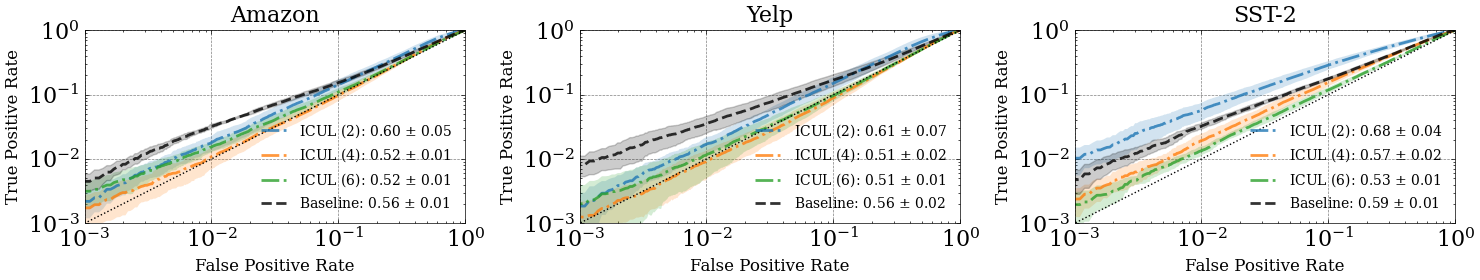

In [12]:
dataset_names = ['Amazon', 'Yelp', 'SST-2'] #['IMDb', 'Amazon', 'Yelp', 'SST-2']
fig, axs = plt.subplots(1, len(datasets), figsize=(len(datasets)*5, 3))
savingtype = 'png'
min_keep = '5'
lr = '1e-05'
for id_data, dataset_name in enumerate(datasets):
    if dataset_name == 'yelp_polarity':
        ctxt_lengths = [2, 4, 6]
    elif dataset_name == 'amazon_polarity':
        ctxt_lengths = [2, 4, 6]
    elif dataset_name == 'sst2':
        ctxt_lengths = [2, 4, 6]
    results = overall_results[dataset_name][f'min_keep{min_keep}']
    for i, nctxt in enumerate(ctxt_lengths):
        '''ICUL'''
        tprs_u = np.array(results['metric_icl'][f'{nctxt}']['tprs']).T
        aucs_u = np.array(results['metric_icl'][f'{nctxt}']['aucs']).T
        mean_tpr_u = np.mean(tprs_u, axis=1)
        std_tpr_u = np.std(tprs_u, axis=1)
        mean_tpr_u[-1] = 1.0
        mean_auc_u = np.mean(aucs_u).round(2)
        std_auc_u = np.std(aucs_u).round(2)
        
        # Unlearn vs Holdout
        axs[id_data].loglog(mean_fpr, mean_tpr_u,
                            label=f"ICUL ({nctxt}): %0.2f $\pm$ %0.2f" % (mean_auc_u, std_auc_u), 
                            lw=2, alpha=0.8, linestyle='dashdot')#, color='tab:green')
        tprs_upper_u = mean_tpr_u + std_tpr_u #np.minimum(mean_tpr_u + std_tpr_u, 1)
        tprs_lower_u = mean_tpr_u - std_tpr_u #np.maximum(mean_tpr_u - std_tpr_u, 0)
        axs[id_data].fill_between(mean_fpr, tprs_lower_u, tprs_upper_u, alpha=0.2)#, color='tab:green')

    '''GA'''
    if False:
        tprs_ga = np.array(results['metric_ga'][lr]['tprs']).T
        aucs_ga = np.array(results['metric_ga'][lr]['aucs']).T
        mean_tpr_ga = np.mean(tprs_ga, axis=1)
        std_tpr_ga = np.std(tprs_ga, axis=1)
        mean_tpr_ga[-1] = 1.0
        mean_auc_ga = np.mean(aucs_ga).round(2)
        std_auc_ga = np.std(aucs_ga).round(2)
        
        # Unlearn vs Holdout
        axs[id_data].loglog(mean_fpr, mean_tpr_ga, 
                            label=f"GA ({lr}): {mean_auc_ga} $\pm$ {std_auc_ga}", 
                            lw=2, alpha=0.8, linestyle='solid', color='tab:red')
        tprs_upper_ga = mean_tpr_ga + std_tpr_ga # np.minimum(mean_tpr_u + std_tpr_u, 1)
        tprs_lower_ga = mean_tpr_ga - std_tpr_ga # np.maximum(mean_tpr_u - std_tpr_u, 0)
        axs[id_data].fill_between(mean_fpr, tprs_lower_ga, tprs_upper_ga, alpha=0.2, color='tab:red') 

    ''' BASELINES '''
    tprs_b = np.array(results[f'metric_base1']['tprs']).T
    aucs_b = np.array(results[f'metric_base1']['aucs']).T
    mean_tpr_b = np.mean(tprs_b, axis=1)
    std_tpr_b = np.std(tprs_b, axis=1)
    mean_tpr_b[-1] = 1.0
    mean_auc_b = np.mean(aucs_b).round(2)
    std_auc_b = np.std(aucs_b).round(2)
    label = 'Baseline' #'Train v. Holdout'
    axs[id_data].loglog(mean_fpr, mean_tpr_b, 
                        label=f"{label}: {mean_auc_b} $\pm$ {std_auc_b}", 
                        lw=2, alpha=0.8, linestyle='dashed', color='black')
    tprs_upper_b = np.minimum(mean_tpr_b + std_tpr_b, 1)
    tprs_lower_b = np.maximum(mean_tpr_b - std_tpr_b, 0)
    axs[id_data].fill_between(mean_fpr, tprs_lower_b, tprs_upper_b, alpha=0.2, color='black') #label=r"$\pm$ 1 std. dev.")
    axs[id_data].plot([0,1], [0,1], linestyle='dotted', color='black', lw=1.0)

    axs[id_data].legend(loc=4)
    axs[id_data].set_xlabel('False Positive Rate', fontsize=12)
    axs[id_data].set_ylabel('True Positive Rate', fontsize=12)
    axs[id_data].set_xlim([0.001, 1])
    axs[id_data].set_ylim([0.001, 1])
    axs[id_data].set_title(dataset_names[id_data])
plt.tight_layout()
plt.savefig(f'results_ubs1/info_extraction_loglog_vary_context_length_{model_name}_{mode}_ubs{ubs}_{context_style}_{regime}_lr{lr}_minkeep{min_keep}.{savingtype}')